In [1]:
# this clones the PGM repository in the ./PGM folder if it does not exists
# please modify this line as needed if you want to have the PMG repository elsewhere
import os, sys
pgm_path = './PGM/'
if not os.path.isdir(pgm_path): # check if folder exists
    from git import Repo
    Repo.clone_from("https://github.com/jertubiana/PGM.git", pgm_path)
sys.path.append('./PGM/source/')
sys.path.append('./PGM/utilities/')
sys.path.append('./DNA_utils/')

In [2]:
# imports
from common_imports import set_num_threads
set_num_threads(2) # Set the number of cores. Must be executed before importing numpy&numba.
import rbm, RBM_utils, utilities
import DNA_utils, DNA_sequence_logo, DNA_plots_utils

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from scipy.optimize import curve_fit

%matplotlib inline

./PGM/source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
./PGM/source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights


In [3]:
# load pre-trained RBM and pre-compute the partition functions
path = './trained_RBMs/'
file_name = 'myrbm-noweights-6th-all_data.data'
RBM_f = RBM_utils.loadRBM(path + file_name)
RBM_f.AIS(n_betas=40000,verbose=0)

Mismatch dimensions (500, 90), [10, 90], reinitializating I
Mismatch dimensions (500, 40, 4), [10, 40, 4], reinitializating I


(172.86191, 0.027822150701467895)

In [4]:
# load full datasets (must be in the ./data folder)
filename = 's100_5th.fasta'
path = './data/'
all_data_5, counts_5 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)
n_tot_5 = all_data_5.shape[0]
seq_len_5 = all_data_5.shape[1]
print('Dataset #5 shape =', all_data_5.shape)

filename = 's100_6th.fasta'
all_data_6, counts_6 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)
n_tot_6 = all_data_6.shape[0]
seq_len_6 = all_data_6.shape[1]
print('Dataset #6 shape =', all_data_6.shape)

filename = 's100_7th.fasta'
all_data_7, counts_7 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)
n_tot_7 = all_data_7.shape[0]
seq_len_7 = all_data_7.shape[1]
print('Dataset #7 shape =', all_data_7.shape)

filename = 's100_8th.fasta'
all_data_8, counts_8 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)
n_tot_8 = all_data_8.shape[0]
seq_len_8 = all_data_8.shape[1]
print('Dataset #8 shape =', all_data_8.shape)

Dataset #5 shape = (891914, 40)
Dataset #6 shape = (735974, 40)
Dataset #7 shape = (744597, 40)
Dataset #8 shape = (719413, 40)


In [5]:
# split left and right loops
# left loops
seqs_5_l_2num, counts_5_l = np.unique(all_data_5[:, :20], return_counts=True, axis=0)
all_data_5_l = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_5_l_2num),
                             'counts' : counts_5_l})
all_data_5_l = all_data_5_l.sort_values(by="counts", ascending=False).reset_index(drop=True)
seqs_6_l_2num, counts_6_l = np.unique(all_data_6[:, :20], return_counts=True, axis=0)
all_data_6_l = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_6_l_2num),
                             'counts' : counts_6_l})
all_data_6_l = all_data_6_l.sort_values(by="counts", ascending=False).reset_index(drop=True)
seqs_7_l_2num, counts_7_l = np.unique(all_data_7[:, :20], return_counts=True, axis=0)
all_data_7_l = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_7_l_2num),
                             'counts' : counts_7_l})
all_data_7_l = all_data_7_l.sort_values(by="counts", ascending=False).reset_index(drop=True)
seqs_8_l_2num, counts_8_l = np.unique(all_data_8[:, :20], return_counts=True, axis=0)
all_data_8_l = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_8_l_2num),
                             'counts' : counts_8_l})
all_data_8_l = all_data_8_l.sort_values(by="counts", ascending=False).reset_index(drop=True)
df_data_l = [all_data_5_l,all_data_6_l,all_data_7_l,all_data_8_l]

# now right loops
seqs_5_r_2num, counts_5_r = np.unique(all_data_5[:, 20:], return_counts=True, axis=0)
all_data_5_r = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_5_r_2num),
                             'counts' : counts_5_r})
all_data_5_r = all_data_5_r.sort_values(by="counts", ascending=False).reset_index(drop=True)
seqs_6_r_2num, counts_6_r = np.unique(all_data_6[:, 20:], return_counts=True, axis=0)
all_data_6_r = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_6_r_2num),
                             'counts' : counts_6_r})
all_data_6_r = all_data_6_r.sort_values(by="counts", ascending=False).reset_index(drop=True)
seqs_7_r_2num, counts_7_r = np.unique(all_data_7[:, 20:], return_counts=True, axis=0)
all_data_7_r = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_7_r_2num),
                             'counts' : counts_7_r})
all_data_7_r = all_data_7_r.sort_values(by="counts", ascending=False).reset_index(drop=True)
seqs_8_r_2num, counts_8_r = np.unique(all_data_8[:, 20:], return_counts=True, axis=0)
all_data_8_r = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_8_r_2num),
                             'counts' : counts_8_r})
all_data_8_r = all_data_8_r.sort_values(by="counts", ascending=False).reset_index(drop=True)
df_data_r = [all_data_5_r,all_data_6_r,all_data_7_r,all_data_8_r]

In [6]:
# Now perform the computations needed for the plots

In [7]:
# panel a: compute likelihoods
liks_5_f = RBM_f.likelihood(np.array(all_data_5))
liks_6_f = RBM_f.likelihood(np.array(all_data_6))
liks_7_f = RBM_f.likelihood(np.array(all_data_7))
liks_8_f = RBM_f.likelihood(np.array(all_data_8))
avs = [np.average(liks_5_f, weights=counts_5), np.average(liks_6_f, weights=counts_6),
       np.average(liks_7_f, weights=counts_7), np.average(liks_8_f, weights=counts_8)]

In [8]:
# computations for panel c: 
# compute number of bins
my_bins = []
nbins = 30
begin = min(liks_5_f)
end = max(liks_8_f)
bin_len = (end - begin) / nbins
p = begin
while p<=end:
    p += bin_len
    my_bins.append(p)

# compute histograms
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
h5_counts, h5_bins, h5_bars = axes[0, 0].hist(liks_5_f, weights=counts_5, bins=my_bins)
h5_x = [(h5_bins[i+1] + h5_bins[i])/2 for i in range(len(h5_bins)-1)]
h5_y = h5_counts.copy()
h6_counts, h6_bins, h6_bars = axes[0, 1].hist(liks_6_f, weights=counts_6, bins=my_bins)
h6_x = [(h6_bins[i+1] + h6_bins[i])/2 for i in range(len(h6_bins)-1)]
h6_y = h6_counts.copy()
h7_counts, h7_bins, h7_bars = axes[1, 0].hist(liks_7_f, weights=counts_7, bins=my_bins)
h7_x = [(h7_bins[i+1] + h7_bins[i])/2 for i in range(len(h7_bins)-1)]
h7_y = h7_counts.copy()
h8_counts, h8_bins, h8_bars = axes[1, 1].hist(liks_8_f, weights=counts_8, bins=my_bins)
h8_x = [(h8_bins[i+1] + h8_bins[i])/2 for i in range(len(h8_bins)-1)]
h8_y = h8_counts.copy()
plt.close() # do not show figure

# compute x and y points to be plotted in panel b
ratio_fit_5 = []
loglik_5 = []
for i in range(len(h5_y)):
    if h5_y[i] == 0 or h6_y[i]==0:
        print('zeros found in pos', i)
        continue
    loglik_5.append((my_bins[i+1]+my_bins[i])/2)
    ratio_fit_5.append(h6_y[i]/h5_y[i])
loglik_6=[]
ratio_fit_6 = []
for i in range(len(h6_y)):
    if h7_y[i] == 0 or h6_y[i]==0:
        print('zeros found in pos', i)
        continue
    loglik_6.append((my_bins[i+1]+my_bins[i])/2)
    ratio_fit_6.append(h7_y[i]/h6_y[i])
ratio_fit_7 = []
loglik_7=[]
for i in range(len(h6_y)):
    if h8_y[i] == 0 or h7_y[i]==0:
        print('zeros found in pos', i)
        continue
    loglik_7.append((my_bins[i+1]+my_bins[i])/2)
    ratio_fit_7.append(h8_y[i]/h7_y[i])
ratio_fit_5 = np.array(ratio_fit_5)
log_ratio_fit_5 = np.log(ratio_fit_5)
ratio_fit_6 = np.array(ratio_fit_6)
log_ratio_fit_6 = np.log(ratio_fit_6)
ratio_fit_7 = np.array(ratio_fit_7)
log_ratio_fit_7 = np.log(ratio_fit_7)

In [9]:
# fit to find center and variance of the peaks, and find seqs in peaks
h5_counts, h5_bins, h5_bars = axes[0, 0].hist(liks_5_f, weights=counts_5, bins=50, density=True)
h5_x = [(h5_bins[i+1] + h5_bins[i])/2 for i in range(len(h5_bins)-1)]
h5_y = h5_counts.copy()
def single_gauss(x, m1, x1, s1):
    return (m1 * np.exp(-(x-x1)**2/(2 * s1)) / np.sqrt(2 * np.pi * s1))
def multi_gauss(x, m1, m2, m3, x1, x2, x3, s1, s2, s3):
    g1 = m1 * np.exp(-(x-x1)**2/(2 * s1)) / np.sqrt(2 * np.pi * s1)
    g2 = m2 * np.exp(-(x-x2)**2/(2 * s2)) / np.sqrt(2 * np.pi * s2)
    g3 = m3 * np.exp(-(x-x3)**2/(2 * s3)) / np.sqrt(2 * np.pi * s3)
    return g1 + g2 + g3
popt5, pcov5 = curve_fit(multi_gauss, h5_x, h5_y, p0 = [0.1, 0.1, 0.1, -57, -42, -28, 10, 10, 10],
                         bounds=([0,0,0,-65,-50,-35,0.01,0.01,0.01], [1,1,1,-55,-35,-20,100,100,100]))
t_pars1 = popt5[[0,3,6]]
t_pars2 = popt5[[1,4,7]]
t_pars3 = popt5[[2,5,8]]
peak1 = (t_pars1[1] - np.sqrt(t_pars1[2]), t_pars1[1] + np.sqrt(t_pars1[2]))
peak2 = (t_pars2[1] - np.sqrt(t_pars2[2]), t_pars2[1] + np.sqrt(t_pars2[2]))
peak3 = (t_pars3[1] - np.sqrt(t_pars3[2]), t_pars3[1] + np.sqrt(t_pars3[2]))
seq_peak1 = []
seq_peak2 = []
seq_peak3 = []
for i, ll in enumerate(liks_5_f):
    if ll > peak1[0] and ll < peak1[1]:
        seq_peak1.append(list(all_data_5[i]))
    if ll > peak2[0] and ll < peak2[1]: 
        seq_peak2.append(list(all_data_5[i]))
    if ll > peak3[0] and ll < peak3[1]:
        seq_peak3.append(list(all_data_5[i]))
seq_peak1 = np.array(seq_peak1)
seq_peak2 = np.array(seq_peak2)
seq_peak3 = np.array(seq_peak3)

In [10]:
# computations for panel d
# normalization factors (so that all rounds have the same number of counts as the 5th)
norm_factors = np.array([t_df["counts"].sum()/all_data_5_l["counts"].sum() for t_df in df_data_l])
# take 100 top-count sequences in round 8 and their counts in previous rounds
# left
top100_l_seq = all_data_8_l.head(100)["sequence"].to_numpy()
top100_l_counts = [[t_df[t_df["sequence"] == s]["counts"].to_list()[0] for t_df in df_data_l] for s in top100_l_seq]
# right
top100_r_seq = all_data_8_r.head(100)["sequence"].to_numpy()
top100_r_counts = [[t_df[t_df["sequence"] == s]["counts"].to_list()[0] for t_df in df_data_r] for s in top100_r_seq]

In [11]:
# make figure

Text(0.015, 0.93, 'd')

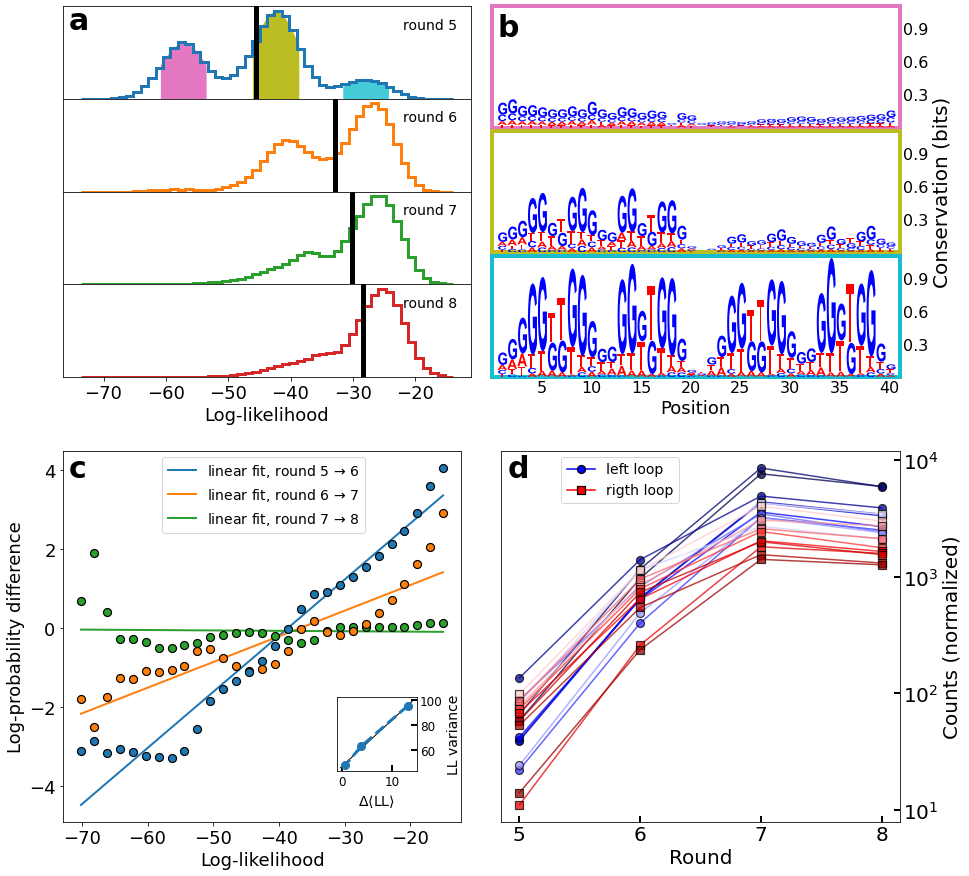

In [16]:
fig = plt.figure(figsize=(15, 15), constrained_layout=False)
gs = fig.add_gridspec(ncols=1, nrows=2, wspace=0.1, hspace=0.2) # I could also choose here some width_ratios or height_ratios

wr0 = [1, 1]
gs1 = gs[0,0].subgridspec(ncols=2, nrows=1, wspace=0.05, hspace=0.1, width_ratios=wr0)
gs2 = gs[1,0].subgridspec(ncols=2, nrows=1, wspace=0.1, hspace=0.1)
#################################################################################################################
# histograms
hr1 = [1, 1, 1, 1]
gs11 = gs1[0,0].subgridspec(ncols=1, nrows=4, height_ratios=hr1, hspace=0.0)
t_pars1 = popt5[[0,3,6]]
t_pars2 = popt5[[1,4,7]]
t_pars3 = popt5[[2,5,8]]
ax11 = fig.add_subplot(gs11[0,0])
ax11.hist(liks_5_f, weights=counts_5, bins=50, density=True, alpha=1, histtype='step', lw=3, fill=False, color="C0")
ax11.axvline(x=avs[0], linewidth=5, color='black', label='Average')
x_fill = np.arange(t_pars1[1] - np.sqrt(t_pars1[2]), t_pars1[1] + np.sqrt(t_pars1[2]), 0.1)
ax11.fill_between(x_fill, single_gauss(x_fill, *t_pars1), facecolor='tab:pink', alpha=1)
x_fill = np.arange(t_pars2[1] - np.sqrt(t_pars2[2]), t_pars2[1] + np.sqrt(t_pars2[2]), 0.1)
ax11.fill_between(x_fill, single_gauss(x_fill, *t_pars2), facecolor='tab:olive', alpha=1)
x_fill = np.arange(t_pars3[1] - np.sqrt(t_pars3[2]), t_pars3[1] + np.sqrt(t_pars3[2]), 0.1)
ax11.fill_between(x_fill, single_gauss(x_fill, *t_pars3), facecolor='tab:cyan', alpha=0.8)
ax11.set_yticks([])
ax11.set_xticks([])
ax11.text(0.9, 0.8, 'round 5', horizontalalignment='center', verticalalignment='center', transform=ax11.transAxes,
             fontsize=14)
ax12 = fig.add_subplot(gs11[1,0])
ax12.hist(liks_6_f, weights=counts_6, bins=50, density=True, histtype='step', lw=3, fill=False, color="C1")
ax12.axvline(x=avs[1], linewidth=5, color='black', label='Average')
ax12.set_yticks([])
ax12.set_xticks([])
ax12.text(0.9, 0.8, 'round 6', horizontalalignment='center', verticalalignment='center', transform=ax12.transAxes,
             fontsize=14)
ax13 = fig.add_subplot(gs11[2,0])
ax13.hist(liks_7_f, weights=counts_7, bins=50, density=True, histtype='step', lw=3, fill=False, color="C2")
ax13.axvline(x=avs[2], linewidth=5, color='black', label='Average')
ax13.set_yticks([])
ax13.set_xticks([])
ax13.text(0.9, 0.8, 'round 7', horizontalalignment='center', verticalalignment='center', transform=ax13.transAxes,
             fontsize=14)
ax14 = fig.add_subplot(gs11[3,0])
ax14.hist(liks_8_f, weights=counts_8, bins=50, density=True, histtype='step', lw=3, fill=False, color="C3")
ax14.axvline(x=avs[3], linewidth=5, color='black', label='Average')
ax14.set_xlabel('Log-likelihood', fontsize=18)
ax14.set_yticks([])
ax14.tick_params(axis='both', which="both", labelsize=18)
ax14.text(0.9, 0.8, 'round 8', horizontalalignment='center', verticalalignment='center', transform=ax14.transAxes,
             fontsize=14)
ax11.text(0.015, 0.75, 'a', fontsize=30, color='k', weight='bold', transform=ax11.transAxes)
#################################################################################################################
gs12 = gs1[0,1].subgridspec(ncols=1, nrows=3, hspace=0.03)

ax21 = fig.add_subplot(gs12[0,0])
rect1 = patches.Rectangle((0.0, 0.0), 1, 1, linewidth=4, edgecolor='tab:pink',
                          facecolor='none', transform=ax21.transAxes, clip_on=False)
ax21.add_patch(rect1)
mu = utilities.average(seq_peak1,c=4)
DNA_sequence_logo.Sequence_logo(mu, ticks_every=5, ax=ax21, show=False, figsize=(5,5))
ax21.set_xticks([])
ax21.set_ylim((0,1.1))
ax21.set_yticks([0.3, 0.6, 0.9])
ax21.tick_params(axis='both', direction='in', length=0, width=2, colors='k')
ax21.tick_params(axis='both', labelsize=16)
ax21.yaxis.tick_right()
ax21.set_ylabel("")
[ax21.spines[x].set_linewidth(0.) for x in ax21.spines.keys()]
ax22 = fig.add_subplot(gs12[1,0])
rect2 = patches.Rectangle((0.0, 0.0), 1, 1, linewidth=4, edgecolor='tab:olive',
                          facecolor='none', transform=ax22.transAxes, clip_on=False)
ax22.add_patch(rect2)
mu = utilities.average(seq_peak2,c=4)
DNA_sequence_logo.Sequence_logo(mu, ticks_every=5, ax=ax22, show=False, figsize=(5,5))
ax22.set_xticks([])
ax22.set_ylim((0,1.1))
ax22.set_yticks([0.3, 0.6, 0.9])
ax22.tick_params(axis='both', direction='in', length=0, width=2, colors='k')
ax22.tick_params(axis='both', labelsize=16)
ax22.yaxis.tick_right()
ax22.yaxis.set_label_position("right")
[ax22.spines[x].set_linewidth(0.) for x in ax21.spines.keys()]
ax23 = fig.add_subplot(gs12[2,0])
rect3 = patches.Rectangle((0.0, 0.0), 1, 1, linewidth=4, edgecolor='tab:cyan',
                          facecolor='none', transform=ax23.transAxes, clip_on=False)
ax23.add_patch(rect3)
mu = utilities.average(seq_peak3,c=4)
DNA_sequence_logo.Sequence_logo(mu, ticks_every=5, ax=ax23, show=False, figsize=(5,5))
ax23.set_ylim((0,1.1))
ax23.set_yticks([0.3, 0.6, 0.9])
ax23.tick_params(axis='both', direction='in', length=0, width=2, colors='k')
ax23.tick_params(axis='both', labelsize=16)
ax23.yaxis.tick_right()
ax23.set_ylabel("")
ax23.set_xlabel('Position', fontsize=18)
[ax23.spines[x].set_linewidth(0.) for x in ax21.spines.keys()]
ax21.text(0.015, 0.75, 'b', fontsize=30, color='k', weight='bold', transform=ax21.transAxes)
#################################################################################################################
ax3 = fig.add_subplot(gs2[0,0])
# fit
# moreover, fit only points with likelihood > -lim
lim = -55
lim = -70
coef5 = np.polyfit(np.array(loglik_5)[np.array(loglik_5)>lim],np.array(log_ratio_fit_5)[np.array(loglik_5)>lim],1)
poly1d_fn5 = np.poly1d(coef5) 
coef6 = np.polyfit(np.array(loglik_6)[np.array(loglik_6)>lim],np.array(log_ratio_fit_6)[np.array(loglik_6)>lim],1)
poly1d_fn6 = np.poly1d(coef6) 
coef7 = np.polyfit(np.array(loglik_7)[np.array(loglik_7)>lim],np.array(log_ratio_fit_7)[np.array(loglik_7)>lim],1)
poly1d_fn7 = np.poly1d(coef7) 
# plot points
ax3.plot(loglik_5, log_ratio_fit_5, 'o', markersize=8, markerfacecolor="C0", markeredgewidth=1.2,
         markeredgecolor="black", zorder=2)
ax3.plot(loglik_6, log_ratio_fit_6, 'o', markersize=8, markerfacecolor="C1", markeredgewidth=1.2,
         markeredgecolor="black", zorder=1)
ax3.plot(loglik_7, log_ratio_fit_7, 'o', markersize=8, markerfacecolor="C2", markeredgewidth=1.2,
         markeredgecolor="black", zorder=0)
# plot fits
xx = np.arange(min(loglik_5), max(loglik_7),0.05)
ax3.plot(xx, poly1d_fn5(xx), color='C0', label=r'linear fit, round 5 $\to$ 6', lw=2, zorder=-1)
ax3.plot(xx, poly1d_fn6(xx), color='C1', label=r'linear fit, round 6 $\to$ 7', lw=2, zorder=-1)
ax3.plot(xx, poly1d_fn7(xx), color='C2', label=r'linear fit, round 7 $\to$ 8', lw=2, zorder=-1)
ax3.legend(fontsize=14, loc=(0.25,0.78))
####################
# inset
avs = [np.average(liks_5_f, weights=counts_5), np.average(liks_6_f, weights=counts_6),
       np.average(liks_7_f, weights=counts_7), np.average(liks_8_f, weights=counts_8)]
var = [np.average(liks_5_f**2, weights=counts_5) - np.average(liks_5_f, weights=counts_5)**2, 
       np.average(liks_6_f**2, weights=counts_6) - np.average(liks_6_f, weights=counts_6)**2, 
       np.average(liks_7_f**2, weights=counts_7) - np.average(liks_7_f, weights=counts_7)**2, 
       np.average(liks_8_f**2, weights=counts_8) - np.average(liks_8_f, weights=counts_8)**2]
x = [avs[i]-avs[i-1] for i in range(1, len(avs))]
y = [var[i] for i in range(len(var)-1)]
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef) 
xx = np.arange(min(x)-1, max(x)+1, 0.05)
axins = inset_axes(ax3, width="100%", height="100%",
                   bbox_to_anchor=(.7, .15, .2, .2),
                   bbox_transform=ax3.transAxes)

axins.plot(x, y, '--o', ms=8, lw=3)
axins.plot(xx, poly1d_fn(xx), color='black', label='linear fit', lw=1, zorder=-5)
axins.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
axins.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
axins.tick_params(axis='both', labelsize=12)
axins.set_xlabel(r'$\Delta\langle$LL$\rangle$', fontsize=14)
axins.set_ylabel("LL variance", fontsize=14)
axins.yaxis.tick_right()
axins.yaxis.set_label_position("right")
####################
ax3.set_xlabel('Log-likelihood', fontsize=18)
ax3.set_ylabel('Log-probability difference', fontsize=18)
ax3.tick_params(axis='both', labelsize=18)
ax3.text(0.015, 0.93, 'c', fontsize=30, color='k', weight='bold', transform=ax3.transAxes)
#################################################################################################################
ax4 = fig.add_subplot(gs2[0,1])
n = 10
cm_l = plt.cm.get_cmap('seismic')
cm_r = plt.cm.get_cmap('seismic')
for i, tp in enumerate(top100_l_counts[:n]):
    ax4.plot(tp * norm_factors, marker='o', alpha=0.75, color=cm_l(0.5 * i/n), markeredgewidth=1.2,
         markeredgecolor="black", markersize=8)
for i, tp in enumerate(top100_r_counts[:n]):
    ax4.plot(tp * norm_factors, marker='s', alpha=0.75, color=cm_r(0.5 + 0.5 * i/n), markeredgewidth=1.2,
         markeredgecolor="black", markersize=8, label="right loop")

leg_handle1 = ax4.plot([], [], marker='o', color=cm_l(0.5 * 0.5), 
                       markeredgewidth=1.2, markeredgecolor="black", markersize=8)[0]
leg_handle2 = ax4.plot([], [], marker='s', color=cm_l(0.5 + 0.5 * 0.5), 
                       markeredgewidth=1.2, markeredgecolor="black", markersize=8)[0]
ax4.legend([leg_handle1, leg_handle2], ["left loop", "rigth loop"] , fontsize=14, ncol=1, loc=(0.15, 0.86))
ax4.set_yscale('log')
ax4.set_ylabel('Counts (normalized)', fontsize=20)
ax4.set_xlabel('Round', fontsize=20)
ax4.set_xticks(np.array([0,1,2,3]))
#ax4.set_xticklabels(["5","6","7","8"])
ax4.set_xticklabels([5,6,7,8])
ax4.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax4.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax4.tick_params(axis='both', labelsize=20)
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.text(0.015, 0.93, 'd', fontsize=30, color='k', weight='bold', transform=ax4.transAxes)

In [ ]:
# now prepare the supplementary figure

In [20]:
# build dataframe of sequences and counts
all_seq_5 = np.array(DNA_utils.num2seq(all_data_5))
all_seq_6 = np.array(DNA_utils.num2seq(all_data_6))
all_seq_7 = np.array(DNA_utils.num2seq(all_data_7))
all_seq_8 = np.array(DNA_utils.num2seq(all_data_8))

full_seqs = np.unique(np.concatenate((all_seq_5, all_seq_6, all_seq_7, all_seq_8)))

all_seqs_5_2counts = dict(zip(all_seq_5, counts_5))
all_seqs_6_2counts = dict(zip(all_seq_6, counts_6))
all_seqs_7_2counts = dict(zip(all_seq_7, counts_7))
all_seqs_8_2counts = dict(zip(all_seq_8, counts_8))
full_counts_5 = []
for s in full_seqs:
    try:
        t_c = all_seqs_5_2counts[s]
        full_counts_5.append(t_c)
    except KeyError:
        full_counts_5.append(0)
full_counts_6 = []
for s in full_seqs:
    try:
        t_c = all_seqs_6_2counts[s]
        full_counts_6.append(t_c)
    except KeyError:
        full_counts_6.append(0)
full_counts_7 = []
for s in full_seqs:
    try:
        t_c = all_seqs_7_2counts[s]
        full_counts_7.append(t_c)
    except KeyError:
        full_counts_7.append(0)
full_counts_8 = []
for s in full_seqs:
    try:
        t_c = all_seqs_8_2counts[s]
        full_counts_8.append(t_c)
    except KeyError:
        full_counts_8.append(0)
full_seqs_df = pd.DataFrame({"seq_id" : full_seqs, "counts_round_5" : full_counts_5, 
                             "counts_round_6" : full_counts_6, "counts_round_7" : full_counts_7, 
                             "counts_round_8" : full_counts_8})

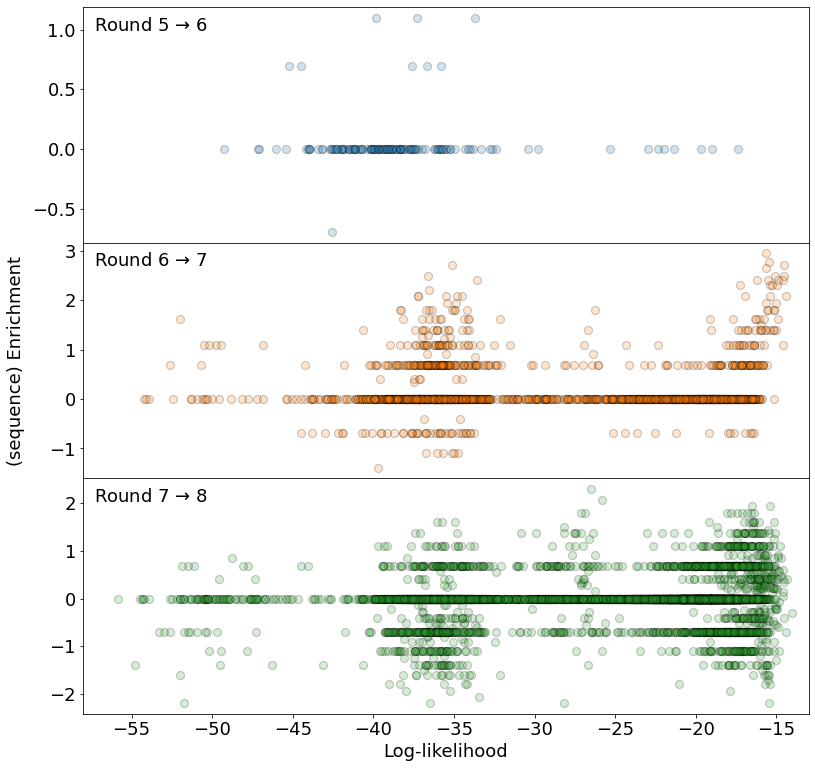

In [21]:
# make plot
fig = plt.figure(figsize=(13,13))
gs = fig.add_gridspec(ncols=1, nrows=3, wspace=0., hspace=0.)
### ax1: 5->6
r1 = "5"
r2 = "6"
t_df = full_seqs_df[(full_seqs_df["counts_round_"+r1] >= 1) & (full_seqs_df["counts_round_"+r2] >= 1)].reset_index(drop=True)
t_ll = RBM_f.likelihood(DNA_utils.seq2num(t_df["seq_id"].to_list()))
t_df["log-likelihood"] = t_ll
x_vals = t_df["log-likelihood"].to_numpy()
y_vals = np.log(t_df["counts_round_"+r2].to_numpy() / t_df["counts_round_"+r1].to_numpy())
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(x_vals, y_vals, 'o', markersize=8, markerfacecolor="C0", markeredgewidth=1.2,
         markeredgecolor="black", zorder=2, alpha=0.2)
ax1.text(0.015, 0.9, "Round "+r1+r" $\to$ "+r2, fontsize=18, color='k', transform=ax1.transAxes)
ax1.tick_params(axis='both', labelsize=18)
ax1.set_xlim((-58,-13))

### ax2: 6->7
r1 = "6"
r2 = "7"
t_df = full_seqs_df[(full_seqs_df["counts_round_"+r1] >= 1) & (full_seqs_df["counts_round_"+r2] >= 1)].reset_index(drop=True)
t_ll = RBM_f.likelihood(DNA_utils.seq2num(t_df["seq_id"].to_list()))
t_df["log-likelihood"] = t_ll
x_vals = t_df["log-likelihood"].to_numpy()
y_vals = np.log(t_df["counts_round_"+r2].to_numpy() / t_df["counts_round_"+r1].to_numpy())
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax2.plot(x_vals, y_vals, 'o', markersize=8, markerfacecolor="C1", markeredgewidth=1.2,
         markeredgecolor="black", zorder=2, alpha=0.2)
ax2.set_ylabel('(sequence) Enrichment', fontsize=18)
ax2.yaxis.set_label_coords(-0.08, 0.5)
ax2.text(0.015, 0.9, "Round "+r1+r" $\to$ "+r2, fontsize=18, color='k', transform=ax2.transAxes)
ax2.tick_params(axis='both', labelsize=18)

### ax3: 7->8
r1 = "7"
r2 = "8"
t_df = full_seqs_df[(full_seqs_df["counts_round_"+r1] >= 1) & (full_seqs_df["counts_round_"+r2] >= 1)].reset_index(drop=True)
t_ll = RBM_f.likelihood(DNA_utils.seq2num(t_df["seq_id"].to_list()))
t_df["log-likelihood"] = t_ll
x_vals = t_df["log-likelihood"].to_numpy()
y_vals = np.log(t_df["counts_round_"+r2].to_numpy() / t_df["counts_round_"+r1].to_numpy())
ax3 = fig.add_subplot(gs[2,0], sharex=ax1)
ax3.plot(x_vals, y_vals, 'o', markersize=8, markerfacecolor="C2", markeredgewidth=1.2,
         markeredgecolor="black", zorder=2, alpha=0.2)
ax3.set_xlabel("Log-likelihood", fontsize=18)
ax3.text(0.015, 0.9, "Round "+ r1 +r" $\to$ "+r2, fontsize=18, color='k', transform=ax3.transAxes)
ax3.tick_params(axis='both', labelsize=18)